<a href="https://colab.research.google.com/github/yoon777/cv_project/blob/main/data_load.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt install tesseract-ocr
!sudo apt-get install tesseract-ocr-kor
!pip install pytesseract
!pip install PyPDF2
!pip install camelot-py[base]
!pip install easyocr
!pip install pdfplumber

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (4,162 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [2]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import pytesseract
import PyPDF2
import camelot

In [3]:
# 구글 드라이브
from google.colab import drive
drive.mount('/content/drive')
image_dir = '/content/drive/MyDrive/CV_project/train_raw'

Mounted at /content/drive


In [4]:
# vscode
# image_dir = 'C:/Users/Yoon/Yoon/2024/BITAMIN/2nd_session/CV_project/032.표_이미지-텍스트_쌍_데이터/조합표/train_raw'

6066
/content/drive/MyDrive/CV_project/train_raw/T02_C01_61002_1589_060.jpg


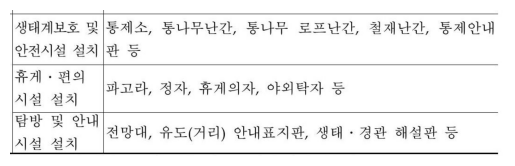

In [5]:
# 이미지 파일 리스트 불러오기
image_files = [f for f in os.listdir(image_dir) if f.startswith('T02_C01') and f.endswith('.jpg')]

print(len(image_files))

# 첫 번째 이미지 불러오기
first_image_path = os.path.join(image_dir, image_files[0])
print(first_image_path)
image = Image.open(first_image_path)

# 이미지 출력
plt.imshow(image)
plt.axis('off')  # 축 숨기기
plt.show()

In [6]:
# 이미지 파일 리스트 불러오기
image_files = [f for f in os.listdir(image_dir) if f.startswith('T02_C01') and f.endswith('.jpg')]

# 이미지 크기 정보를 저장할 리스트
widths = []
heights = []

# 이미지 개수
total_images = len(image_files)

# 이미지 크기 비교 및 업데이트
for i, image_file in enumerate(tqdm(image_files)):
    image_path = os.path.join(image_dir, image_file)
    img = Image.open(image_path)

    height, width = img.size

    widths.append(width)
    heights.append(height)

  1%|          | 63/6066 [02:41<4:16:19,  2.56s/it] 


KeyboardInterrupt: 

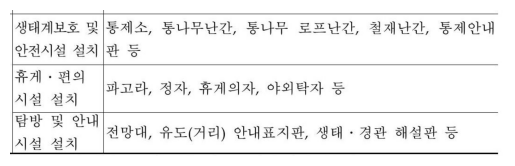

                                     text  xmin  xmax  ymin  ymax
0                           (생태계보호 및 통제소,     5   303    17    61
1                                  통나무난간    319   483    19    61
2                                     통나무   499   597    19    61
3                                  로프난간 ,   612   744    23    61
4                                  철재난간 ,   757   895    21    61
5                                    통제안내   909  1037    19    61
6                         (안전시설 설치 |판   등     4   283    66   110
7                                 휴게 . 편의     9   163   125   165
8               파고라   정자   휴게 의자  야외탁자  등   201   717   146   189
9                                 시설   설치     5   149   173   213
10                              담방   및 안내     7   193   217   257
11  전망대 ,  유도(거리) 안내표지판   생태 . 경관   해설판 등   199   959   240   285
12                                  시설 설치     7   149   269   305


In [33]:
import easyocr
import pandas as pd

# 이미지 읽기
img_path = os.path.join(image_dir, image_files[0])  # 첫 번째 이미지 선택
img = Image.open(img_path)  # PIL 이미지로 열기

# 이미지 출력 (원본 이미지 시각화)
plt.imshow(img)
plt.axis('off')  # 축 숨기기
plt.show()

# OCR 모델 초기화 (한국어 및 영어 지원)
reader = easyocr.Reader(['ko', 'en'])

# 이미지에서 텍스트 및 좌표 추출
results = reader.readtext(img)

# 좌표와 텍스트를 데이터프레임으로 변환
data = []
for (bbox, text, confidence) in results:
    # bbox는 좌표 정보, text는 인식된 텍스트
    (top_left, top_right, bottom_right, bottom_left) = bbox
    xmin = min(top_left[0], bottom_left[0])
    xmax = max(top_right[0], bottom_right[0])
    ymin = min(top_left[1], top_right[1])
    ymax = max(bottom_left[1], bottom_right[1])

    # 좌표와 텍스트 정보를 저장
    data.append({
        'text': text,
        'xmin': xmin,
        'xmax': xmax,
        'ymin': ymin,
        'ymax': ymax
    })

df = pd.DataFrame(data)
print(df)

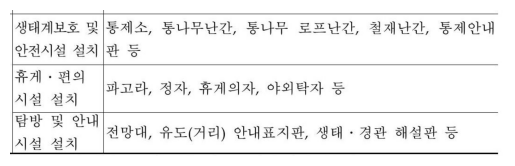

In [34]:
# 이미지 출력
plt.imshow(img)
plt.axis('off')  # 축 숨기기
plt.show()

In [11]:
## 2. 딥러닝 모델 준비
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import requests

# ResNet 모델 불러오기 (사전 학습된 모델 사용)
model = models.resnet50(pretrained=True)
model.eval()  # 평가 모드로 전환

# 이미지 전처리
preprocess = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 이미지 로드
img_path = os.path.join(image_dir, image_files[0])  # 첫 번째 이미지 선택
img = Image.open(img_path)  # PIL 이미지로 열기
img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0)

# 이미지 예측
with torch.no_grad():
  output = model(batch_t)

# ImageNet 클래스 이름 로드
# URL에서 ImageNet 클래스 레이블 다운로드
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
response = requests.get(url)

# 텍스트 데이터를 라인별로 리스트에 저장
labels = [line.strip() for line in response.text.splitlines()]

# 결과에서 가장 높은 확률의 클래스 가져오기
_, index = torch.max(output, 1)
percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100
print(f"Predicted: {labels[index[0]]}, Confidence: {percentage[index[0]].item()}%")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predicted: screw, Confidence: 15.570100784301758%


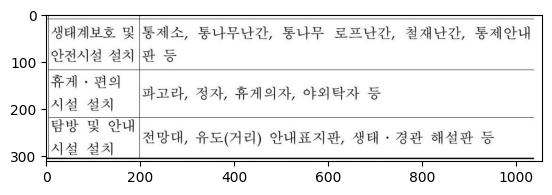

In [13]:
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as T
import matplotlib.patches as patches

# Pre-trained Faster R-CNN 모델 로드 (최신 가중치 사용)
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)
model.eval()

# 이미지 불러오기 및 전처리 (크기 조정 포함)
image = Image.open(img_path)
transform = T.Compose([T.Resize((800, 600)), T.ToTensor()])
img = transform(image)

# 이미지에서 객체 탐지
with torch.no_grad():
    prediction = model([img])

# 점수 임계값 설정 (탐지된 객체 필터링)
threshold = 0.2
boxes = prediction[0]['boxes']
labels = prediction[0]['labels']
scores = prediction[0]['scores']

# 임계값보다 큰 점수에 대해 필터링
filtered_boxes = boxes[scores > threshold]
filtered_labels = labels[scores > threshold]
filtered_scores = scores[scores > threshold]

# 탐지된 객체 시각화
fig, ax = plt.subplots(1)
ax.imshow(image)

# 필터된 결과를 시각화
for i in range(len(filtered_boxes)):
    box = filtered_boxes[i]
    rect = patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

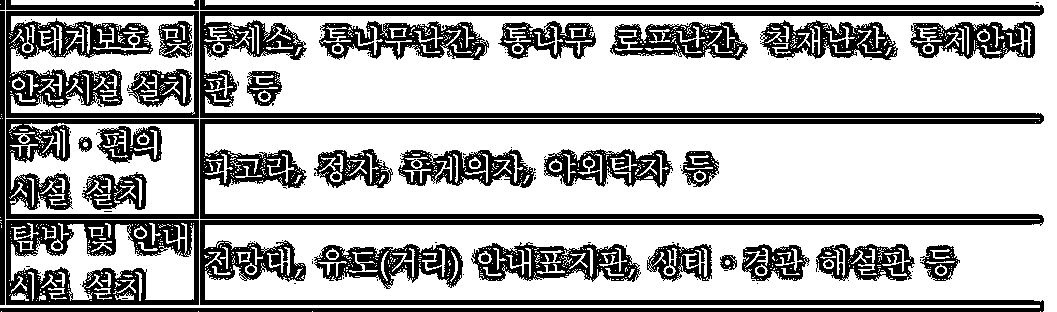

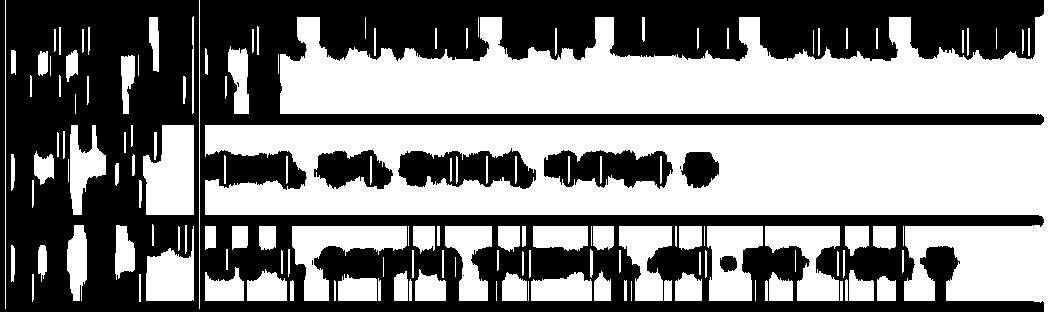

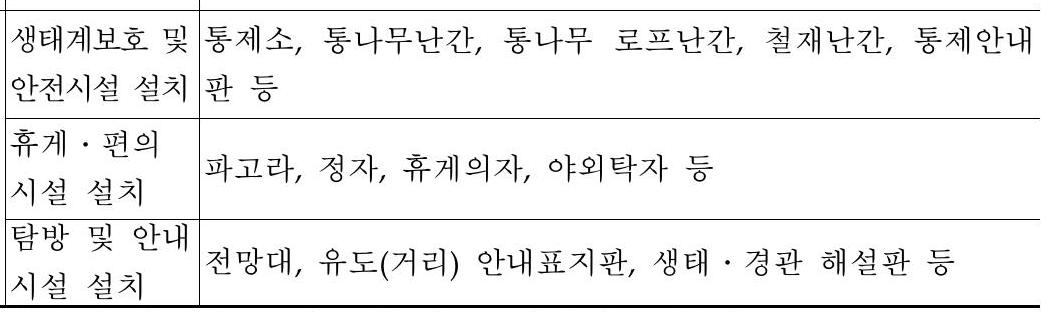

In [28]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow  # Colab에서 이미지를 표시하기 위한 패치

# 이미지 파일 경로 및 전처리 옵션 설정
process_background = False  # 배경 처리 여부 (True 또는 False로 설정)
blocksize = 11  # Adaptive Threshold에서 사용되는 blocksize 값
c = 2  # Adaptive Threshold에서 사용되는 상수 값
line_scale = 15  # 세로 또는 가로선 크기 조정용 스케일
direction = "vertical"  # 방향 설정: 'vertical' 또는 'horizontal'
regions = None  # 특정 영역이 있다면 [(x, y, w, h), ...] 형태로 입력
iterations = 2  # 팽창(dilation) 반복 횟수

# 이미지 읽기
img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 배경 처리에 따른 이진화
if process_background:
    threshold = cv2.adaptiveThreshold(
        gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, blocksize, c
    )
else:
    threshold = cv2.adaptiveThreshold(
        np.invert(gray),
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        blocksize,
        c,
    )

# 중간 결과 출력: 이진화 이미지
cv2_imshow(threshold)  # Colab에서 이진화된 이미지를 표시
cv2.waitKey(0)

# 세로 또는 가로 방향에 맞는 구조화 요소 설정
if direction == "vertical":
    size = threshold.shape[0] // line_scale
    el = cv2.getStructuringElement(cv2.MORPH_RECT, (1, size))
elif direction == "horizontal":
    size = threshold.shape[1] // line_scale
    el = cv2.getStructuringElement(cv2.MORPH_RECT, (size, 1))
else:
    raise ValueError("Specify direction as either 'vertical' or 'horizontal'")

# 특정 영역만 처리할 경우
if regions is not None:
    region_mask = np.zeros(threshold.shape)
    for region in regions:
        x, y, w, h = region
        region_mask[y : y + h, x : x + w] = 1
    threshold = np.multiply(threshold, region_mask)

# 팽창과 침식으로 선을 감지
threshold = cv2.erode(threshold, el)
threshold = cv2.dilate(threshold, el)
dmask = cv2.dilate(threshold, el, iterations=iterations)

# 중간 결과 출력: 침식 및 팽창 처리 후 이미지
cv2_imshow(threshold)  # Colab에서 처리된 이미지를 표시
cv2.waitKey(0)

# 테이블 외곽선 검출
contours, _ = cv2.findContours(
    threshold.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)

# 테이블 좌표 추출
lines = []
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if direction == "vertical":
        lines.append(((x + x + w) // 2, y + h, (x + x + w) // 2, y))
    elif direction == "horizontal":
        lines.append((x, (y + y + h) // 2, x + w, (y + y + h) // 2))

# 세로선과 가로선이 교차하는 곳 탐지
vertical = np.zeros_like(threshold)
horizontal = np.zeros_like(threshold)
mask = vertical + horizontal
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

# 교차점 및 테이블 셀 정보 추출
joints = np.multiply(vertical, horizontal)
tables = {}
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    roi = joints[y : y + h, x : x + w]
    jc, _ = cv2.findContours(roi.astype(np.uint8), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    if len(jc) <= 4:
        continue
    joint_coords = [(x + (2 * jx + jw) // 2, y + (2 * jy + jh) // 2) for j in jc]
    tables[(x, y + h, x + w, y)] = joint_coords

# 최종 결과 이미지에 테이블 외곽선 표시
for table_coords, joints in tables.items():
    x1, y1, x2, y2 = table_coords
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # 테이블 외곽선
    for joint in joints:
        cv2.circle(img, joint, 3, (255, 0, 0), -1)  # 조인트 포인트

# 중간 결과 출력: 최종 이미지
cv2_imshow(img)  # Colab에서 최종 이미지를 표시
cv2.waitKey(0)
cv2.destroyAllWindows()

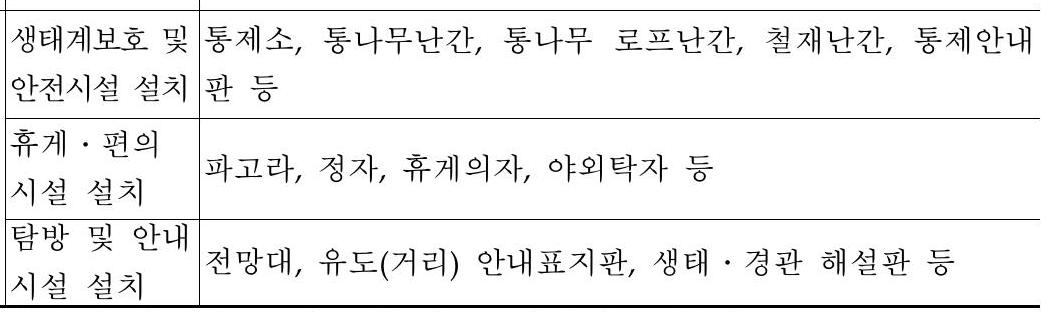

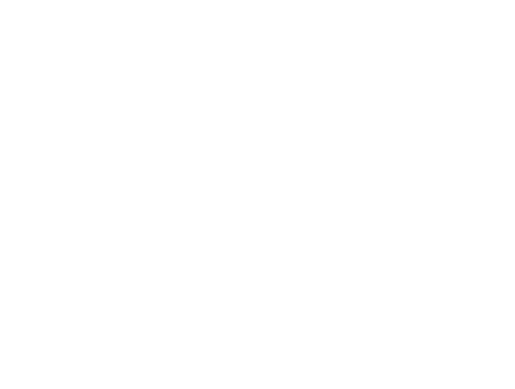

                                     text  xmin  xmax  ymin  ymax
0                           (생태계보호 및 통제소,     5   303    17    61
1                                  통나무난간    319   483    19    61
2                                     통나무   499   597    19    61
3                                  로프난간 ,   612   744    23    61
4                                  철재난간 ,   757   895    21    61
5                                    통제안내   909  1037    19    61
6                         (안전시설 설치 |판   등     4   283    66   110
7                                 휴게 . 편의     9   163   125   165
8               파고라   정자   휴게 의자  야외탁자  등   201   717   146   189
9                                 시설   설치     5   149   173   213
10                              담방   및 안내     7   193   217   257
11  전망대 ,  유도(거리) 안내표지판   생태 . 경관   해설판 등   199   959   240   285
12                                  시설 설치     7   149   269   305


In [29]:
import easyocr
import pandas as pd

# 이미지 출력 (원본 이미지 시각화)
cv2_imshow(img)
plt.axis('off')  # 축 숨기기
plt.show()

# OCR 모델 초기화 (한국어 및 영어 지원)
reader = easyocr.Reader(['ko', 'en'])

# 이미지에서 텍스트 및 좌표 추출
results = reader.readtext(img)

# 좌표와 텍스트를 데이터프레임으로 변환
data = []
for (bbox, text, confidence) in results:
    # bbox는 좌표 정보, text는 인식된 텍스트
    (top_left, top_right, bottom_right, bottom_left) = bbox
    xmin = min(top_left[0], bottom_left[0])
    xmax = max(top_right[0], bottom_right[0])
    ymin = min(top_left[1], top_right[1])
    ymax = max(bottom_left[1], bottom_right[1])

    # 좌표와 텍스트 정보를 저장
    data.append({
        'text': text,
        'xmin': xmin,
        'xmax': xmax,
        'ymin': ymin,
        'ymax': ymax
    })

df = pd.DataFrame(data)
print(df)